# Notebook 5: Deutsch's Algorithm

📘 **Notebook 5/7**: Deutsch's Algorithm  
⏱️  **Estimated Duration**: 18 min  
🎯 **What You'll Learn**:
   • Understand quantum oracles (black-box functions)
   • Implement Deutsch's algorithm
   • Solve problems with 1 query (classical needs 2!)
   • Grasp quantum parallelism concept

**Progress**: ⬛⬛⬛⬛⬛⬛⬜ (5/7)

---

## 🎯 The First Quantum Algorithm

We've explored superposition, interference, and entanglement.

**Now**: Let's use these properties to **compute** something useful!

**Deutsch's algorithm (1985)**: First proof that quantum computers can be fundamentally faster than classical ones! 🚀

## Section 1: Environment Setup

Let's import our quantum tools for implementing Deutsch's algorithm.

In [1]:
# Quantum computing framework
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Visualization and numerical tools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom plotting utilities
import sys
sys.path.append('..')
from utils.plotting import configure_beautiful_plots, COLORS

# Configure beautiful plots
configure_beautiful_plots()

# Create simulator
simulator = AerSimulator()

print("✅ All imports successful!")
print("✅ Ready to explore Deutsch's algorithm")

✅ All imports successful!
✅ Ready to explore Deutsch's algorithm


## 🤔 INTUITION: The Deutsch Problem

Imagine you have a mysterious function (oracle) that takes 1 bit as input and gives 1 bit as output.

**The function f(x)** can be one of 4 types:
1. **Constant 0**: f(0) = 0, f(1) = 0 → always returns 0
2. **Constant 1**: f(0) = 1, f(1) = 1 → always returns 1
3. **Identity**: f(0) = 0, f(1) = 1 → returns input
4. **NOT**: f(0) = 1, f(1) = 0 → returns opposite of input

### 🎯 The Question

**Is the function constant or balanced?**
- **Constant**: f(0) = f(1) (returns same value for both inputs)
- **Balanced**: f(0) ≠ f(1) (returns different values)

### 🖥️ Classical Solution

**You MUST query the function 2 times** (once with 0, once with 1) to know for sure.

In [2]:
# Classical solution - need 2 queries
def classical_deutsch(f):
    """
    Determine if function f is constant or balanced.
    Returns: 'constant' or 'balanced'
    """
    # Query 1: evaluate f(0)
    result_0 = f(0)
    print(f"Query 1: f(0) = {result_0}")
    
    # Query 2: evaluate f(1)
    result_1 = f(1)
    print(f"Query 2: f(1) = {result_1}")
    
    # Compare results
    if result_0 == result_1:
        return 'constant'
    else:
        return 'balanced'

# Define the 4 possible functions
def f_constant_0(x):
    return 0

def f_constant_1(x):
    return 1

def f_identity(x):
    return x

def f_not(x):
    return 1 - x

# Test all functions
functions = [
    ('Constant 0', f_constant_0),
    ('Constant 1', f_constant_1),
    ('Identity (balanced)', f_identity),
    ('NOT (balanced)', f_not)
]

print("🖥️ Classical Deutsch Problem Solution\n")
print("=" * 50)

for name, func in functions:
    print(f"\nFunction: {name}")
    result = classical_deutsch(func)
    print(f"Result: {result}")
    print("-" * 50)

print("\n💡 Classical cost: 2 queries per function")
print("   Can we do better with quantum? YES! ⚛️")

🖥️ Classical Deutsch Problem Solution


Function: Constant 0
Query 1: f(0) = 0
Query 2: f(1) = 0
Result: constant
--------------------------------------------------

Function: Constant 1
Query 1: f(0) = 1
Query 2: f(1) = 1
Result: constant
--------------------------------------------------

Function: Identity (balanced)
Query 1: f(0) = 0
Query 2: f(1) = 1
Result: balanced
--------------------------------------------------

Function: NOT (balanced)
Query 1: f(0) = 1
Query 2: f(1) = 0
Result: balanced
--------------------------------------------------

💡 Classical cost: 2 queries per function
   Can we do better with quantum? YES! ⚛️


## 💡 CONCEPT: Quantum Oracles

In quantum computing, we can't just "return" a value like classical functions.

**Why?** Quantum operations must be:
- **Reversible** (unitary)
- **Preserve quantum information**

### 🔮 Solution: The Oracle as a Unitary Gate

We encode f(x) into a **quantum gate U_f** that acts on 2 qubits:

$$U_f |x\rangle |y\rangle = |x\rangle |y \oplus f(x)\rangle$$

Where ⊕ is XOR (addition modulo 2).

**Properties**:
- Input qubit |x> stays unchanged
- Output qubit |y> becomes y ⊕ f(x)
- Operation is reversible (apply twice → identity)

### 🎯 Special Case: |y> = |->

If we use |y> = |-> = (|0> - |1>)/√2 as the output qubit:

$$U_f |x\rangle |-> = (-1)^{f(x)} |x\rangle |->$$

This encodes f(x) as a **phase** on the input qubit! 🤯

This is called **phase kickback**.

## Section 2: Implementing Quantum Oracles

Let's implement the 4 possible oracles for Deutsch's problem.

⚛️ Quantum Oracles for Deutsch Problem


Oracle: Constant 0


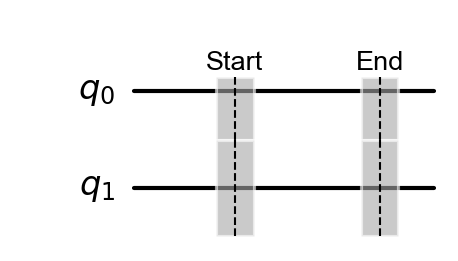


Oracle: Constant 1


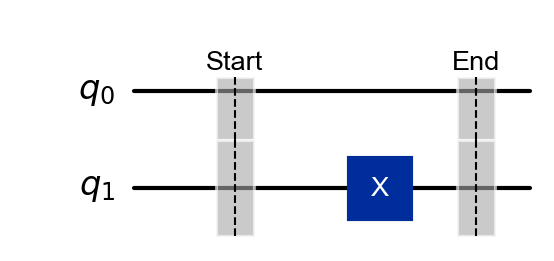


Oracle: Identity


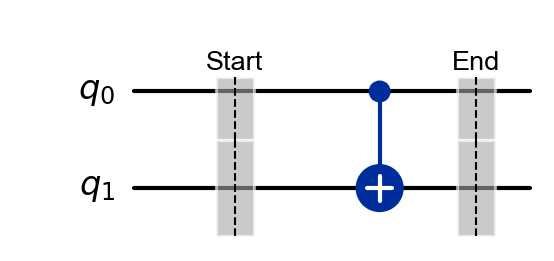


Oracle: NOT


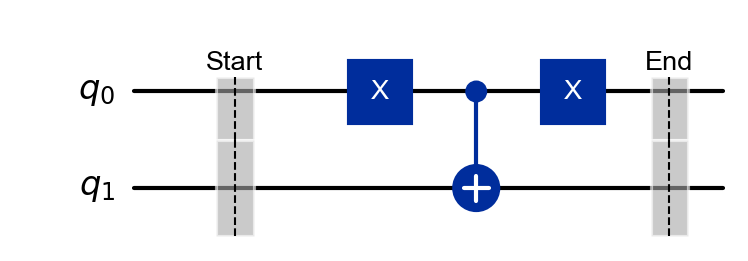


✅ All 4 oracles implemented!


In [3]:
# Define quantum oracles as circuits
def oracle_constant_0(qc, x, y):
    """
    Constant 0: f(x) = 0
    U_f |x>|y> = |x>|y ⊕ 0> = |x>|y>
    No operation needed!
    """
    pass  # Identity - do nothing

def oracle_constant_1(qc, x, y):
    """
    Constant 1: f(x) = 1
    U_f |x>|y> = |x>|y ⊕ 1> = |x>|NOT(y)>
    Apply X gate to output qubit
    """
    qc.x(y)

def oracle_identity(qc, x, y):
    """
    Identity: f(x) = x
    U_f |x>|y> = |x>|y ⊕ x>
    Use CNOT: flips y if x is 1
    """
    qc.cx(x, y)

def oracle_not(qc, x, y):
    """
    NOT: f(x) = NOT(x) = 1-x
    U_f |x>|y> = |x>|y ⊕ (1-x)>
    Apply X to y, then CNOT, then X to y again
    Or equivalently: X(y) then CNOT(x,y)
    """
    qc.x(x)      # Flip input
    qc.cx(x, y)  # CNOT
    qc.x(x)      # Flip back

# Visualize all oracles
print("⚛️ Quantum Oracles for Deutsch Problem\n")

oracles = [
    ('Constant 0', oracle_constant_0),
    ('Constant 1', oracle_constant_1),
    ('Identity', oracle_identity),
    ('NOT', oracle_not)
]

for name, oracle_func in oracles:
    print(f"\nOracle: {name}")
    print("=" * 40)
    
    # Create circuit with 2 qubits
    qc = QuantumCircuit(2)
    qc.barrier(label='Start')
    
    # Apply oracle
    oracle_func(qc, 0, 1)  # qubit 0 = x, qubit 1 = y
    
    qc.barrier(label='End')
    
    # Draw circuit
    display(qc.draw('mpl'))
    
print("\n✅ All 4 oracles implemented!")

## 🎯 CHECKPOINT 1: Can you...

- [ ] Explain the Deutsch problem (constant vs balanced)?
- [ ] Understand why classical needs 2 queries?
- [ ] Explain what a quantum oracle is?
- [ ] Implement the 4 oracles as quantum gates?

Great! Now let's see the quantum algorithm! 🚀

---

## 💡 CONCEPT: Deutsch's Algorithm

Now for the magic! ✨

### 🎯 The Algorithm

**Circuit**:
```
q0 (x): |0> ──H──[ Oracle ]──H──M──
                     │
q1 (y): |1> ──H──[   U_f   ]──────
```

**Steps**:
1. Initialize: |0>|1>
2. Apply H to both qubits → |+>|->
3. Apply oracle U_f (with phase kickback!)
4. Apply H to first qubit
5. Measure first qubit

**Result**:
- Measure **0** → function is **constant**
- Measure **1** → function is **balanced**

**Only 1 query needed!** 🤯

### 🧮 How It Works

After step 2: |ψ> = |+>|-> = [ (|0> + |1>)/√2 ] |->

After oracle (using phase kickback):
$$|\psi\rangle = \frac{1}{\sqrt{2}}[(-1)^{f(0)}|0\rangle + (-1)^{f(1)}|1\rangle] |->$$

This evaluates f at **both 0 and 1 simultaneously** (quantum parallelism!)

After final H:
- If f(0) = f(1) (constant) → phases cancel → measure 0
- If f(0) ≠ f(1) (balanced) → phases interfere → measure 1

## 💻 IMPLEMENTATION: Deutsch's Algorithm

⚛️ Deutsch's Algorithm - Testing All Oracles


🔮 Oracle: Constant 0
------------------------------------------------------------

Circuit:


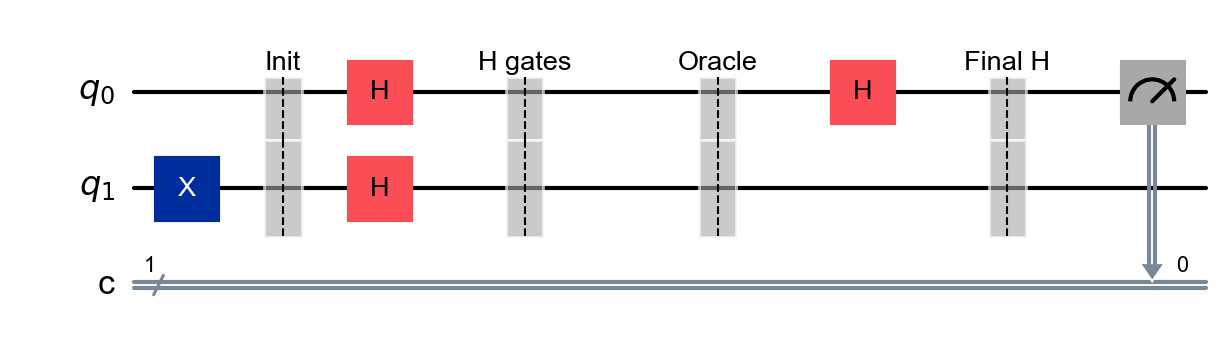


📊 Measurement results (1000 shots):
   {'0': 1000}

🎯 Conclusion: Function is Constant


🔮 Oracle: Constant 1
------------------------------------------------------------

Circuit:


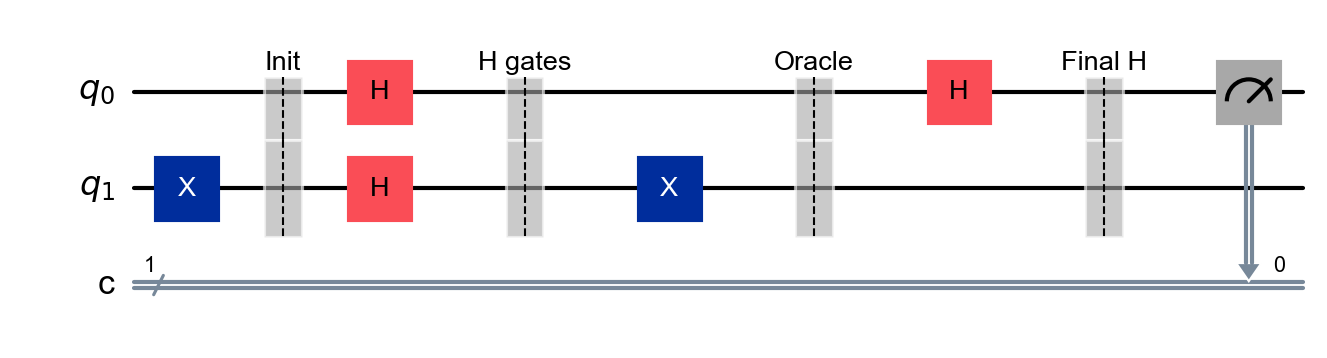


📊 Measurement results (1000 shots):
   {'0': 1000}

🎯 Conclusion: Function is Constant


🔮 Oracle: Identity
------------------------------------------------------------

Circuit:


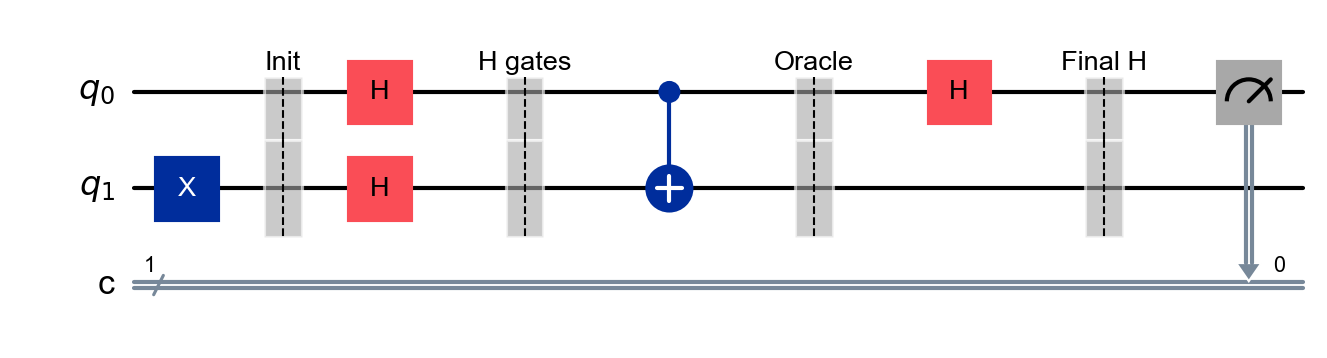


📊 Measurement results (1000 shots):
   {'1': 1000}

🎯 Conclusion: Function is Balanced


🔮 Oracle: NOT
------------------------------------------------------------

Circuit:


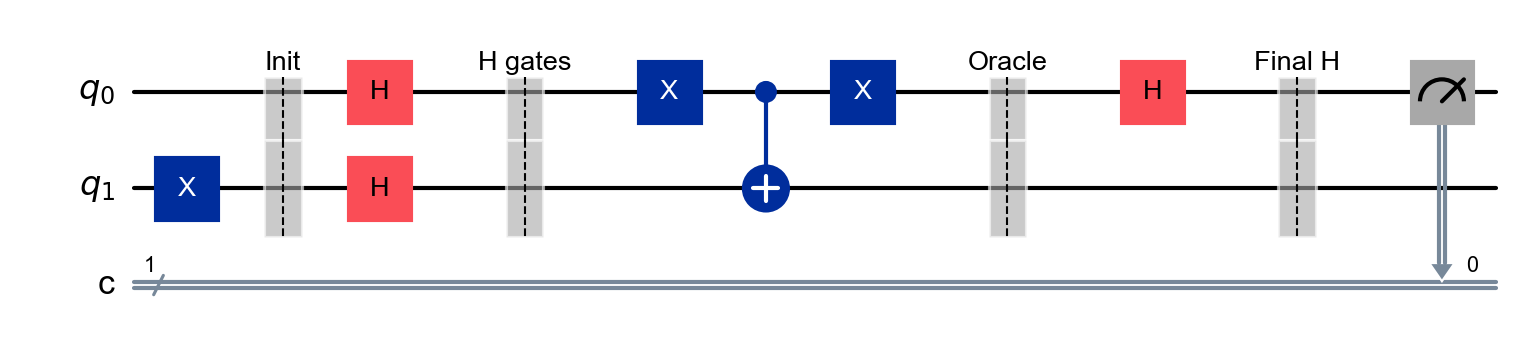


📊 Measurement results (1000 shots):
   {'1': 1000}

🎯 Conclusion: Function is Balanced


✅ Algorithm complete! All oracles tested with 1 query each!


In [4]:
def deutsch_algorithm(oracle_func, oracle_name):
    """
    Implement Deutsch's algorithm with given oracle.
    
    Args:
        oracle_func: Function that applies oracle to circuit
        oracle_name: Name of the oracle for display
        
    Returns:
        Measurement result (0 = constant, 1 = balanced)
    """
    # Create circuit: 2 qubits, 1 classical bit
    qc = QuantumCircuit(2, 1)
    
    # Step 1: Initialize second qubit to |1>
    qc.x(1)
    qc.barrier(label='Init')
    
    # Step 2: Apply Hadamard to both qubits
    # Creates |+>|->
    qc.h(0)
    qc.h(1)
    qc.barrier(label='H gates')
    
    # Step 3: Apply oracle
    oracle_func(qc, 0, 1)
    qc.barrier(label='Oracle')
    
    # Step 4: Apply Hadamard to first qubit
    qc.h(0)
    qc.barrier(label='Final H')
    
    # Step 5: Measure first qubit
    qc.measure(0, 0)
    
    return qc

# Test on all 4 oracles
print("⚛️ Deutsch's Algorithm - Testing All Oracles\n")
print("=" * 60)

results = []

for oracle_name, oracle_func in oracles:
    print(f"\n🔮 Oracle: {oracle_name}")
    print("-" * 60)
    
    # Build circuit
    qc = deutsch_algorithm(oracle_func, oracle_name)
    
    # Display circuit
    print("\nCircuit:")
    display(qc.draw('mpl'))
    
    # Execute
    job = simulator.run(qc, shots=1000)
    counts = job.result().get_counts()
    
    # Interpret result
    if '0' in counts and counts.get('0', 0) > 500:
        result = 'Constant'
    else:
        result = 'Balanced'
    
    print(f"\n📊 Measurement results (1000 shots):")
    print(f"   {counts}")
    print(f"\n🎯 Conclusion: Function is {result}")
    
    results.append((oracle_name, result, counts))
    print("\n" + "=" * 60)

print("\n✅ Algorithm complete! All oracles tested with 1 query each!")

## 📊 VISUALIZATION: Comparing Classical vs Quantum

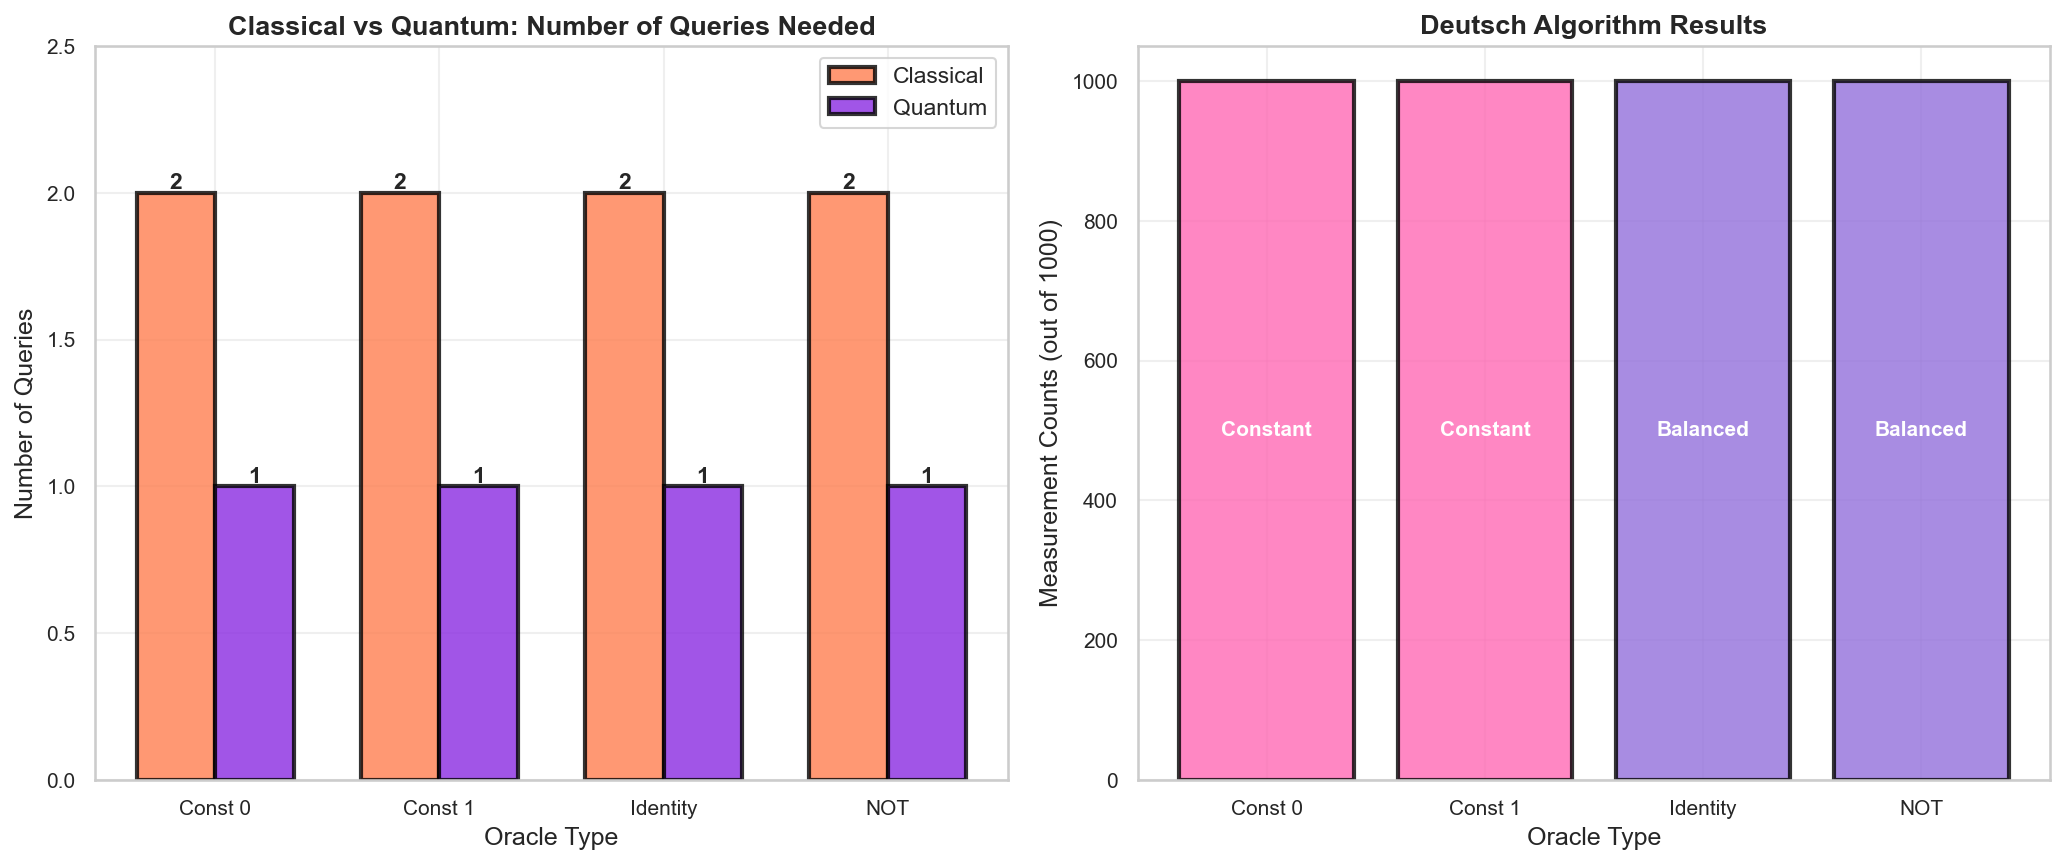


🎯 Key Insights:
   • Classical: Always needs 2 queries
   • Quantum: Only needs 1 query!
   • Speedup: 2× faster (for this problem)

💡 This demonstrates quantum advantage through:
   1. Quantum parallelism (evaluating both inputs at once)
   2. Quantum interference (combining results constructively/destructively)


In [5]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

# Classical queries needed
classical_queries = [2, 2, 2, 2]  # Always 2
quantum_queries = [1, 1, 1, 1]    # Always 1
oracle_names_short = ['Const 0', 'Const 1', 'Identity', 'NOT']

# Bar chart 1: Number of queries
x = np.arange(len(oracle_names_short))
width = 0.35

bars1 = ax1.bar(x - width/2, classical_queries, width, 
                label='Classical', color=COLORS['classical'], 
                edgecolor='black', linewidth=2, alpha=0.8)
bars2 = ax1.bar(x + width/2, quantum_queries, width,
                label='Quantum', color=COLORS['quantum'],
                edgecolor='black', linewidth=2, alpha=0.8)

ax1.set_xlabel('Oracle Type', fontsize=12)
ax1.set_ylabel('Number of Queries', fontsize=12)
ax1.set_title('Classical vs Quantum: Number of Queries Needed', 
              fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(oracle_names_short)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 2.5)

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Bar chart 2: Results distribution
results_data = []
for oracle_name, result, counts in results:
    if result == 'Constant':
        results_data.append(counts.get('0', 0))
    else:
        results_data.append(counts.get('1', 0))

colors_results = [COLORS['primary'] if 'Const' in name else COLORS['secondary'] 
                  for name in oracle_names_short]

bars3 = ax2.bar(oracle_names_short, results_data, 
                color=colors_results, edgecolor='black', 
                linewidth=2, alpha=0.8)

ax2.set_xlabel('Oracle Type', fontsize=12)
ax2.set_ylabel('Measurement Counts (out of 1000)', fontsize=12)
ax2.set_title('Deutsch Algorithm Results', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Annotate with result type
for i, (bar, (oracle_name, result, _)) in enumerate(zip(bars3, results)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height/2,
            result,
            ha='center', va='center', fontsize=10, fontweight='bold',
            color='white', rotation=0)

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print("   • Classical: Always needs 2 queries")
print("   • Quantum: Only needs 1 query!")
print("   • Speedup: 2× faster (for this problem)")
print("\n💡 This demonstrates quantum advantage through:")
print("   1. Quantum parallelism (evaluating both inputs at once)")
print("   2. Quantum interference (combining results constructively/destructively)")

## 🎯 CHECKPOINT 2: Can you...

- [ ] Explain the 5 steps of Deutsch's algorithm?
- [ ] Understand why it only needs 1 query?
- [ ] Explain quantum parallelism (evaluating both inputs)?
- [ ] Explain how interference gives the answer?

Excellent! You've mastered the first quantum algorithm! 🎉

---

## 🎯 Quick Quiz

Test your understanding of Deutsch's algorithm!

**1. The Deutsch problem asks if a function is:**
- [ ] Fast or slow
- [x] Constant or balanced
- [ ] Linear or quadratic

**2. Classically, we need:**
- [ ] 1 query
- [x] 2 queries
- [ ] 3 queries

**3. With Deutsch's algorithm, we need:**
- [x] 1 query
- [ ] 2 queries
- [ ] 0 queries

**4. A quantum oracle must be:**
- [x] Reversible (unitary)
- [ ] Irreversible
- [ ] Random

**5. Phase kickback occurs when:**
- [ ] We measure the first qubit
- [x] We use |-> as the output qubit
- [ ] We apply Hadamard gates

**6. Quantum parallelism means:**
- [ ] Running multiple circuits at once
- [x] Evaluating function on multiple inputs simultaneously
- [ ] Using multiple quantum computers

**7. If we measure 0, the function is:**
- [x] Constant
- [ ] Balanced
- [ ] Undefined

**8. If we measure 1, the function is:**
- [ ] Constant
- [x] Balanced
- [ ] Undefined

## 🎯 FINAL CHECKPOINT: Can you...

Before moving to the next notebook, verify you can:

- [ ] Explain the Deutsch problem clearly?
- [ ] Implement all 4 quantum oracles?
- [ ] Trace through the Deutsch algorithm step by step?
- [ ] Explain quantum parallelism and interference?
- [ ] Understand why we measure 0 for constant, 1 for balanced?
- [ ] Appreciate this is the first quantum advantage proof?

If yes to all, congratulations! You understand quantum algorithms! 🎉

---

## 🎓 Notebook 5 Summary

**What you learned:**
✅ Deutsch problem: determine if function is constant or balanced  
✅ Classical solution: needs 2 queries  
✅ Quantum oracles: reversible gates encoding functions  
✅ Phase kickback: encoding result as phase  
✅ Deutsch's algorithm: solves with 1 query!  
✅ Quantum parallelism: evaluate both inputs simultaneously  
✅ Quantum interference: combine results to get answer  

**Progress**: ⬛⬛⬛⬛⬛⬛⬜ (6/7 completed)

---

## 🚀 Next Step: Notebook 6 - Quantum Teleportation

We've seen quantum computation. Now for something truly mind-bending!

**Coming up**:
- Transfer quantum states without transmission
- Use entanglement and classical communication
- Understand the "no-cloning" principle in action
- Complete implementation of teleportation protocol

The most famous quantum protocol! 🌟

See you soon! 🎉